## Particle Filtering for Robust Point Correspondence and F matrix estimation

- Using right-handed coordinates in this example
- E matrix is now E = TR (translation and rotation)
- Added quantisation (round image points to 3 d.p.)
- Added extra noise points
- Sample full range of 5 dimensions

2018-07-17: Start particle filter with ground truth 
- Check that ground truth has perfect score
- Experiment with small m (few samples) and small sigma
- Try increasing sigma and epsilon

2018-07-24: Start with uniform cube of samples around the solution
- Added quantisation and noise points (epsilon cannot go below 0.0005)
- Add further constraint - enforce one-to-one epiline-point matching

2018-08-17: Experiments + Vectorised epiline-point matching
- Can use more sample points (m) thanks to faster vectorised matching
- Use absolute dists instead of sqdists
- Sample full range of 5 dimensions (-pi to pi, except for one dimension that is halved due to scale ambiguity)
- Visualise the sample point scores with a colour map

# Part I: Simulate view of scene with perspective projection

In [ ]:
# from google.colab import files
# src = list(files.upload().values())[0]
# open('helpers.py','wb').write(src)

In [1]:
import helpers
import numpy as np
from helpers import projectPoints, transformCamera
from math import sin, cos, pi

In [2]:
# Define n random points in 1x1x1 cube centred at (0,0,2): 

n_corr = 20

# p = np.random.rand(n,3)*2 - 1.0 + np.array([[0,0,2.0]])

p = np.array([[ 0.47729982,  0.46821197,  2.82519478],
              [ 0.42268141, -0.24521877,  1.35673245],
              [-0.01436486,  0.47451121,  2.54364829],
              [ 0.22221251, -0.67802847,  2.48401469],
              [ 0.53139288,  0.98989222,  1.90058383],
              [ 0.26739713, -0.57282862,  2.08571485],
              [-0.00420308, -0.8873651 ,  2.30317347],
              [ 0.95345022, -0.45281222,  1.64367242],
              [-0.43965872, -0.42929066,  2.8768967 ],
              [-0.03042594, -0.44432101,  2.00269752],
              [-0.27269807, -0.61922827,  2.9905221 ],
              [ 0.33509766, -0.42812641,  2.17759225],
              [-0.6597356 , -0.65676217,  1.78080565],
              [ 0.79502118,  0.42769441,  2.68382864],
              [-0.70730296,  0.2737345 ,  2.23520083],
              [ 0.44392226,  0.32736849,  1.82209446],
              [-0.71203014,  0.04881414,  2.67555491],
              [ 0.54053719, -0.77533631,  1.12262847],
              [-0.03883526,  0.44478417,  2.47103904],
              [ 0.94593446,  0.01870913,  2.37024429]])

In [3]:
# Define camera parameters

f  = 1          # focal length
bu = bv = 1     # scaling factors
u0 = v0 = 0     # offsets

# Define camera position (0, 0, 0) 
cam_pos = np.array([0.0, 0.0, 0.0])

# Define camera orientation in world coordinates (aligned to world, rows are i, j, k vectors)
cam_or = np.eye(3)

In [4]:
u, v = projectPoints(p, cam_pos, cam_or, f, bu, bv, u0, v0)

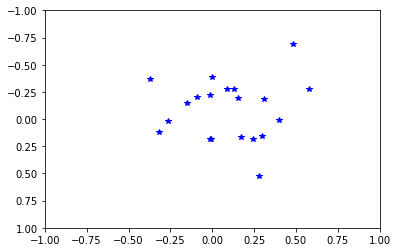

In [5]:
%matplotlib inline 
import matplotlib.pyplot as plt

plt.plot(u, v, 'b*')
plt.axis([-bu, bu, -bv, bv])
plt.gca().invert_yaxis()
plt.show()

## Interactive display of view from different camera positions and orientations 

In [6]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(transformCamera, p=fixed(p), display=fixed(True),
         x     = (-2.0, +2.0, 0.01), 
         y     = (-2.0, +2.0, 0.01), 
         z     = (-2.0, +2.0, 0.01),
         roll  = ( -pi,  +pi, 0.01),   
         pitch = ( -pi,  +pi, 0.01),   
         yaw   = ( -pi,  +pi, 0.01),
         f=fixed(1), bu=fixed(1), bv=fixed(1), u0=fixed(0), v0=fixed(0)
        ) 

A Jupyter Widget

<function helpers.transformCamera>

-------------------------
# Part II: Particle Filter with TR as E matrix (assume K = I)

1. Set up two camera positions (translation and rotation)
2. Sample possible translation and rotation in 3 dimensions each, using particle filtering

## Set up two camera positions 

In [6]:
from helpers import cartesianToSpherical

# Set up diff in (x, y, z, r, p, y) between the two cameras
diff = np.array([2.0, -0.7, 1.0, 0.5, -0.4, -1.0])
z1   = 0.3
pts1 = transformCamera(p, display=False, x=0, y=0, z=z1, roll=0, pitch=0, yaw=0)
pts2 = transformCamera(p, display=False, x=diff[0], y=diff[1], z=z1+diff[2], roll=diff[3], pitch=diff[4], yaw=diff[5])

# Add noise points
num_noise = 5
pts1 = np.concatenate((pts1, np.random.rand(num_noise, 2)*2 - 1.0), axis = 0)
pts2 = np.concatenate((pts2, np.random.rand(num_noise, 2)*2 - 1.0), axis = 0)

# Quantise image points to 3 d.p.
pts1 = np.around(pts1,3)
pts2 = np.around(pts2,3)

# In spherical coordinates
r, theta, phi = cartesianToSpherical(diff[0], diff[1], diff[2])
diff_sph = np.array([theta, phi, diff[3], diff[4], diff[5]])

### List pts1 and pts2:

In [7]:
# Points are fixed for debugging at the moment
pts1 = np.array([[ 0.189, 0.185], [ 0.4 , -0.232], [-0.006, 0.211], [ 0.102, -0.31 ], [ 0.332, 0.618], [ 0.15 , -0.321], [-0.002, -0.443], [ 0.71 , -0.337], [-0.171, -0.167], [-0.018, -0.261], [-0.101, -0.23 ], [ 0.178, -0.228], [-0.446, -0.444], [ 0.334, 0.179], [-0.365, 0.141], [ 0.292, 0.215], [-0.3 , 0.021], [ 0.657, -0.943], [-0.018, 0.205], [ 0.457, 0.009], [ 0.789, 0.955], [ 0.048, 0.33 ], [-0.956, -0.838], [-0.346, 0.23 ], [ 0.641, -0.765]], dtype='float32')
pts2 = np.array([[ 0.423, 0.509], [-0.421, 0.485], [ 0.17 , 0.507], [ 0.075, 0.022], [ 0.162, 1.138], [-0.067, 0.119], [-0.069, -0.037], [-0.134, 0.306], [ 0.083, 0.106], [-0.145, 0.196], [ 0.13 , 0.026], [ 0.01 , 0.179], [-0.332, 0.138], [ 0.521, 0.578], [-0.088, 0.417], [-0.021, 0.711], [ 0.022, 0.282], [-0.73 , 0.161], [ 0.136, 0.506], [ 0.412, 0.443], [-0.491, 0.086], [-0.135, -0.912], [-0.321, 0.002], [ 0.6 , -0.35 ], [ 0.428, -0.009]], dtype='float32')

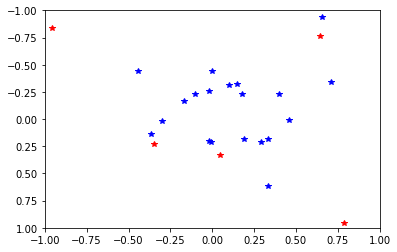

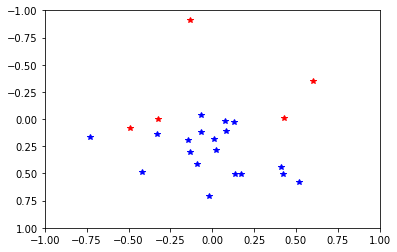

([-1, 1, -1, 1], None, None)

In [8]:
# Display pts1 and pts2
plt.plot(pts1[:n_corr, 0], pts1[:n_corr, 1], 'b*'), plt.plot(pts1[n_corr:, 0], pts1[n_corr:, 1], 'r*')
plt.axis([-bu, bu, -bv, bv]), plt.gca().invert_yaxis(), plt.show()
plt.plot(pts2[:n_corr, 0], pts2[:n_corr, 1], 'b*'), plt.plot(pts2[n_corr:, 0], pts2[n_corr:, 1], 'r*')
plt.axis([-bu, bu, -bv, bv]), plt.gca().invert_yaxis(), plt.show()

## 2. Run Particle Filter

In [9]:
from importlib import reload
reload(helpers)

<module 'helpers' from 'D:\\Courses\\NUS\\DCVPC\\code\\helpers.py'>

D:\Courses\NUS\DCVPC\code\helpers.py:186: RuntimeWarning: invalid value encountered in less
  all_matches = dists < epsilon


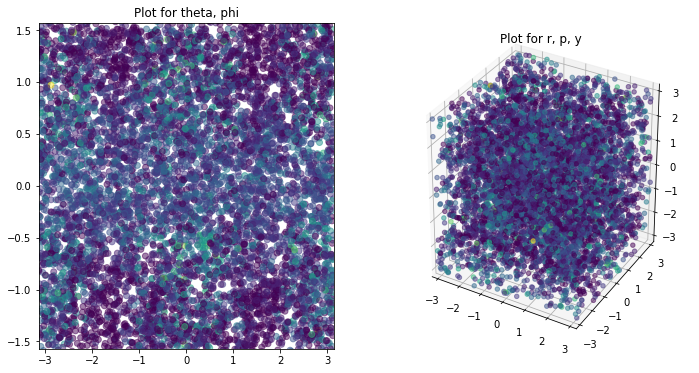

First 200 scores: [3, 3, 4, 3, 0, 5, 0, 3, 1, 2, 5, 2, 4, 1, 4, 1, 2, 3, 0, 1, 3, 4, 1, 2, 9, 2, 2, 1, 0, 0, 1, 1, 3, 0, 3, 3, 0, 0, 4, 2, 0, 6, 4, 3, 0, 4, 4, 1, 5, 3, 1, 4, 3, 3, 0, 2, 2, 1, 2, 0, 3, 1, 1, 1, 6, 0, 4, 0, 1, 4, 3, 3, 1, 1, 2, 7, 1, 3, 2, 1, 0, 4, 1, 1, 0, 0, 2, 2, 0, 0, 1, 2, 4, 4, 2, 3, 1, 0, 1, 2, 1, 3, 5, 6, 2, 0, 0, 0, 5, 0, 1, 2, 2, 5, 1, 3, 2, 3, 2, 1, 0, 3, 0, 2, 0, 2, 0, 1, 2, 1, 4, 2, 2, 1, 2, 1, 2, 2, 0, 1, 1, 0, 4, 1, 7, 4, 6, 2, 4, 0, 0, 2, 3, 0, 5, 1, 5, 0, 2, 0, 6, 0, 7, 2, 8, 0, 0, 5, 2, 5, 2, 0, 5, 2, 0, 1, 3, 2, 3, 0, 0, 0, 2, 1, 3, 0, 0, 0, 1, 2, 6, 5, 1, 1, 7, 3, 1, 8, 3, 1]
Non-match ratio: 0.966430 (16323/16890)
Sigma: ['0.080000', '0.080000', '0.080000', '0.080000', '0.080000']
Epsilon: 0.010000
Iteration: 1
Elapsed time: 6.709873s


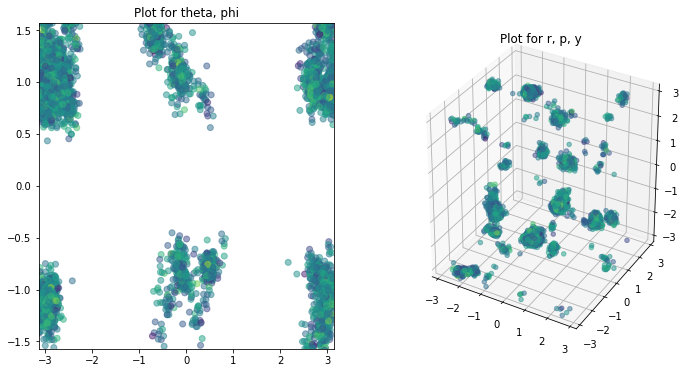

First 200 scores: [6, 4, 6, 6, 9, 6, 6, 5, 7, 7, 4, 7, 7, 7, 4, 5, 8, 8, 6, 7, 8, 6, 9, 6, 5, 5, 4, 9, 6, 6, 5, 7, 9, 9, 8, 8, 9, 5, 12, 3, 5, 8, 4, 8, 8, 6, 6, 9, 8, 7, 7, 8, 9, 9, 8, 8, 10, 10, 10, 6, 4, 7, 7, 6, 6, 5, 5, 4, 7, 6, 5, 6, 7, 4, 6, 7, 8, 6, 9, 5, 7, 7, 6, 5, 9, 5, 8, 4, 3, 6, 8, 4, 7, 9, 9, 6, 8, 7, 11, 6, 5, 6, 6, 6, 10, 6, 9, 7, 6, 10, 6, 7, 8, 8, 5, 6, 7, 4, 6, 7, 6, 8, 6, 7, 8, 3, 4, 6, 7, 4, 5, 8, 3, 4, 9, 7, 4, 6, 6, 3, 7, 10, 7, 7, 9, 3, 5, 9, 4, 6, 11, 4, 5, 5, 5, 8, 2, 4, 5, 8, 10, 6, 5, 7, 6, 7, 9, 9, 5, 5, 4, 8, 3, 6, 7, 6, 6, 9, 8, 7, 9, 7, 9, 5, 9, 5, 9, 8, 4, 4, 9, 10, 6, 4, 7, 5, 7, 9, 8, 4]
Non-match ratio: 0.965229 (50662/52487)
Sigma: ['0.064000', '0.064000', '0.064000', '0.064000', '0.064000']
Epsilon: 0.010000
Iteration: 6
Elapsed time: 36.231686s


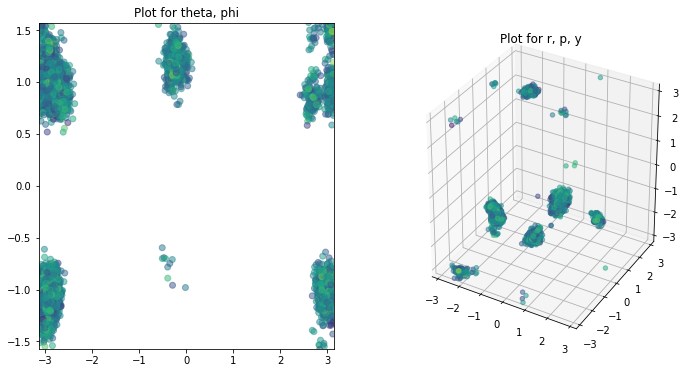

First 200 scores: [5, 6, 5, 4, 11, 8, 7, 11, 3, 7, 8, 3, 9, 10, 8, 8, 8, 6, 5, 4, 9, 7, 5, 5, 9, 10, 4, 6, 8, 9, 5, 8, 8, 4, 9, 10, 6, 8, 7, 8, 7, 6, 7, 8, 7, 9, 9, 7, 7, 5, 8, 9, 9, 9, 6, 9, 9, 7, 4, 7, 5, 9, 5, 7, 4, 8, 4, 7, 7, 6, 9, 4, 6, 11, 7, 7, 9, 4, 8, 8, 9, 5, 6, 8, 5, 5, 6, 9, 6, 9, 5, 7, 8, 13, 8, 10, 9, 7, 9, 9, 6, 3, 9, 8, 6, 7, 5, 6, 7, 5, 10, 11, 5, 3, 7, 6, 4, 7, 9, 8, 7, 5, 5, 7, 6, 5, 8, 7, 6, 9, 6, 11, 11, 8, 7, 5, 7, 10, 10, 6, 9, 7, 6, 13, 6, 3, 5, 8, 8, 5, 6, 6, 9, 6, 8, 5, 9, 9, 7, 6, 6, 7, 6, 7, 10, 4, 8, 8, 4, 6, 3, 6, 7, 6, 7, 8, 12, 8, 6, 7, 4, 9, 8, 6, 7, 8, 7, 10, 7, 7, 9, 5, 9, 6, 7, 7, 6, 7, 7, 8]
Non-match ratio: 0.930913 (52429/56320)
Sigma: ['0.051200', '0.051200', '0.051200', '0.051200', '0.051200']
Epsilon: 0.010000
Iteration: 11
Elapsed time: 65.140964s


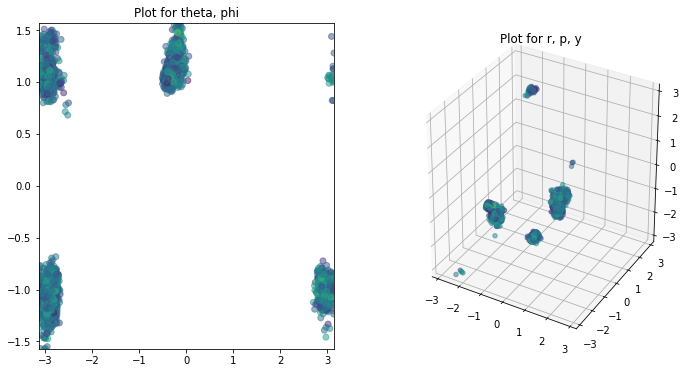

First 200 scores: [10, 7, 7, 5, 5, 5, 11, 7, 5, 9, 5, 10, 6, 7, 7, 4, 8, 3, 10, 4, 6, 10, 11, 7, 7, 9, 7, 7, 9, 13, 9, 5, 6, 9, 5, 13, 5, 8, 2, 5, 10, 8, 10, 8, 8, 9, 6, 9, 9, 6, 9, 10, 6, 7, 4, 8, 5, 7, 6, 8, 4, 9, 6, 8, 9, 10, 6, 5, 10, 9, 6, 9, 7, 8, 4, 9, 6, 5, 8, 12, 11, 6, 9, 7, 3, 4, 9, 5, 6, 7, 6, 6, 7, 6, 11, 9, 6, 9, 7, 6, 9, 5, 8, 10, 3, 7, 7, 8, 9, 6, 12, 10, 10, 11, 9, 2, 8, 8, 10, 5, 6, 5, 6, 7, 3, 5, 11, 8, 5, 9, 10, 9, 5, 10, 7, 6, 9, 6, 10, 5, 8, 7, 10, 5, 10, 4, 7, 13, 6, 9, 5, 4, 9, 8, 8, 11, 8, 8, 10, 8, 9, 8, 8, 14, 11, 13, 7, 6, 8, 8, 7, 6, 3, 9, 8, 8, 5, 7, 8, 4, 9, 6, 7, 10, 7, 7, 8, 6, 5, 6, 10, 7, 6, 13, 8, 8, 5, 10, 10, 9]
Non-match ratio: 0.875861 (52754/60231)
Sigma: ['0.040960', '0.040960', '0.040960', '0.040960', '0.040960']
Epsilon: 0.010000
Iteration: 16
Elapsed time: 93.770258s


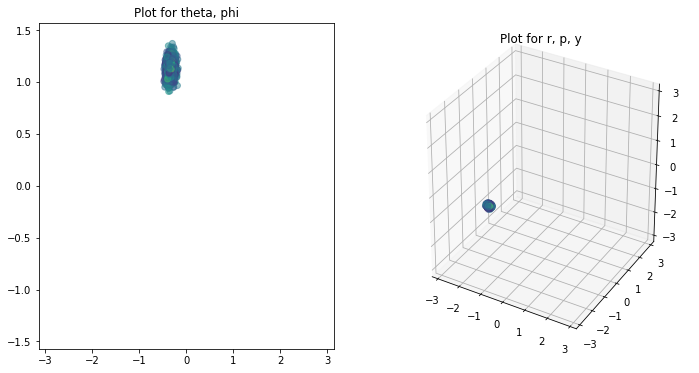

First 200 scores: [15, 8, 13, 11, 8, 7, 10, 7, 13, 7, 8, 7, 7, 11, 8, 7, 9, 6, 10, 10, 7, 7, 12, 7, 8, 5, 10, 13, 8, 9, 10, 9, 4, 5, 9, 8, 6, 8, 7, 7, 9, 5, 10, 14, 6, 12, 7, 5, 10, 7, 8, 9, 7, 6, 8, 8, 10, 6, 7, 5, 6, 11, 12, 14, 8, 8, 7, 6, 4, 5, 5, 7, 14, 4, 5, 13, 7, 9, 8, 6, 5, 7, 8, 9, 7, 8, 10, 13, 10, 3, 4, 9, 9, 6, 9, 6, 6, 8, 5, 8, 8, 8, 9, 13, 6, 8, 10, 7, 6, 6, 4, 9, 8, 7, 11, 3, 7, 6, 5, 6, 6, 11, 6, 10, 15, 6, 15, 6, 7, 9, 8, 7, 7, 10, 5, 9, 6, 11, 10, 4, 7, 13, 9, 7, 8, 8, 7, 5, 12, 10, 7, 13, 6, 9, 9, 5, 8, 5, 8, 9, 11, 5, 9, 7, 9, 6, 9, 7, 9, 6, 5, 8, 10, 10, 7, 9, 6, 16, 9, 5, 8, 16, 12, 3, 12, 9, 8, 6, 7, 7, 7, 7, 9, 9, 8, 6, 4, 6, 12, 8]
Non-match ratio: 0.697793 (45053/64565)
Sigma: ['0.032768', '0.032768', '0.032768', '0.032768', '0.032768']
Epsilon: 0.010000
Iteration: 21
Elapsed time: 122.851677s


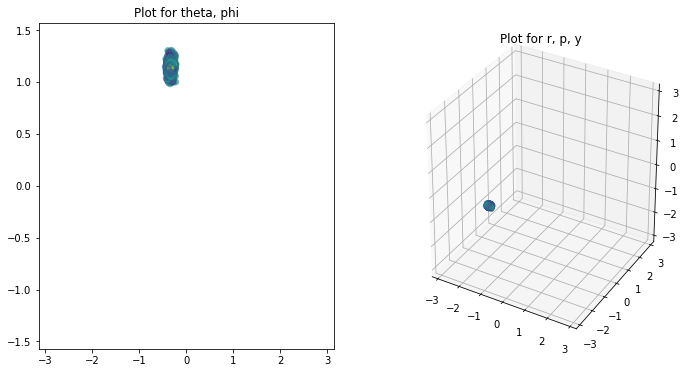

First 200 scores: [7, 6, 10, 7, 4, 11, 9, 6, 11, 9, 10, 7, 9, 15, 14, 10, 3, 13, 7, 5, 7, 6, 6, 8, 12, 18, 4, 4, 7, 11, 15, 7, 4, 7, 14, 14, 5, 15, 10, 14, 5, 11, 5, 7, 9, 7, 12, 7, 10, 7, 7, 9, 6, 6, 6, 11, 12, 9, 10, 8, 8, 6, 6, 6, 10, 3, 6, 14, 8, 9, 6, 8, 8, 9, 8, 6, 9, 14, 5, 7, 6, 6, 13, 7, 13, 11, 7, 6, 14, 5, 4, 8, 10, 9, 8, 8, 4, 10, 16, 7, 5, 5, 9, 13, 14, 6, 4, 6, 9, 8, 9, 11, 8, 8, 9, 17, 8, 6, 7, 8, 6, 6, 5, 9, 5, 7, 8, 10, 13, 8, 14, 10, 7, 10, 7, 6, 7, 9, 8, 4, 7, 10, 12, 7, 6, 5, 9, 6, 5, 6, 10, 6, 12, 11, 13, 13, 4, 12, 8, 6, 8, 4, 11, 11, 10, 7, 5, 7, 10, 10, 10, 15, 13, 6, 6, 4, 8, 5, 7, 6, 11, 10, 8, 7, 7, 6, 14, 5, 10, 9, 5, 10, 8, 4, 11, 11, 11, 6, 7, 8]
Non-match ratio: 0.628471 (43367/69004)
Sigma: ['0.026214', '0.026214', '0.026214', '0.026214', '0.026214']
Epsilon: 0.010000
Iteration: 26
Elapsed time: 152.954022s


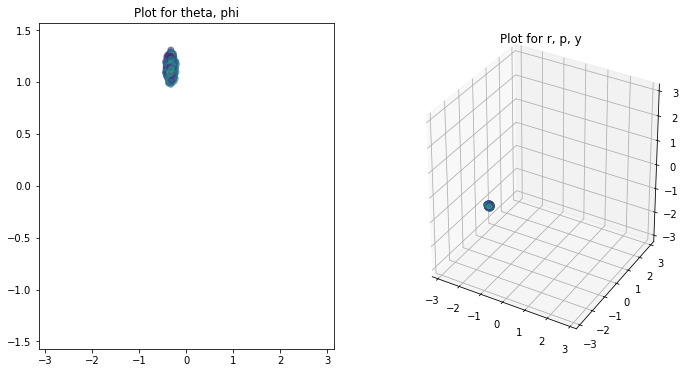

First 200 scores: [16, 6, 9, 10, 5, 8, 5, 17, 4, 11, 6, 5, 12, 9, 7, 7, 8, 7, 10, 6, 15, 5, 6, 13, 13, 9, 6, 8, 6, 9, 14, 11, 13, 8, 15, 16, 7, 15, 11, 2, 9, 6, 5, 5, 14, 7, 4, 13, 18, 5, 11, 8, 11, 6, 5, 7, 11, 6, 5, 6, 11, 8, 5, 7, 4, 5, 6, 4, 8, 4, 9, 13, 16, 11, 6, 10, 7, 7, 9, 6, 9, 9, 6, 8, 10, 5, 14, 8, 2, 13, 6, 5, 6, 6, 8, 5, 10, 5, 7, 14, 5, 10, 14, 7, 4, 5, 5, 6, 5, 10, 7, 9, 10, 10, 15, 6, 9, 10, 10, 12, 7, 8, 6, 10, 6, 18, 7, 14, 11, 13, 5, 5, 12, 7, 4, 6, 6, 6, 8, 6, 9, 8, 12, 12, 4, 9, 13, 6, 12, 13, 6, 6, 13, 9, 7, 13, 7, 8, 4, 7, 13, 6, 8, 6, 8, 7, 4, 5, 6, 8, 13, 9, 9, 7, 5, 5, 7, 8, 5, 6, 7, 8, 8, 13, 9, 10, 6, 6, 4, 7, 7, 13, 7, 14, 4, 8, 12, 9, 8, 3]
Non-match ratio: 0.633777 (43576/68756)
Sigma: ['0.026214', '0.026214', '0.026214', '0.026214', '0.026214']
Epsilon: 0.010000
Iteration: 30
Elapsed time: 176.684326s


In [69]:
from helpers import ParticleFilter, generateSamples
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import time

start_time = time.time()
# ---------------------------------------------------------
# Adjustable parameters
# ---------------------------------------------------------

iterations = 30
m = 8000

# Set range to be a uniform cube of length 1 around the solution
# ranges = np.array([[*diff_sph-0.5, 1/m], [*diff_sph+0.5, 1/m]]).T  

ranges = np.array([[-pi, pi],
                   [-pi/2, pi/2],
                   [-pi, pi], 
                   [-pi, pi], 
                   [-pi, pi], 
                   [1/m, 1/m]])

e = 0.01
sigma = np.array([*[0.08]*5]) 

# Multiply sigma by a factor after a number of iterations
sigma_factor   = 0.8
sigma_interval = 5 

# Multiply epsilon by a factor after a number of iterations
e_factor   = 1 #0.5
e_interval = 5

# ---------------------------------------------------------

S_new = generateSamples(m, ranges)

for i in range(iterations):
    S_new, score_list, nmc, mc = ParticleFilter(S_new, sigma, pts1, pts2, n_corr, epsilon = e, epipole_t = 0.3, norm_mode = "softmax")
    
    # Print for every 5 iterations, and for the last iteration
    if i%5 == 0 or i+1 == iterations: 
        fig = plt.figure(figsize = (18,6))

        ax1 = fig.add_subplot(131)
        ax1.scatter(*S_new[:2,:], c= score_list, alpha=0.5)
        ax1.set_xlim(*ranges[0])
        ax1.set_ylim(*ranges[1])
        ax1.set_title("Plot for theta, phi")
        
        ax2 = fig.add_subplot(132, projection='3d')
        ax2.scatter(*S_new[2:5,:], c= score_list, alpha=0.5)
        ax2.set_xlim3d(*ranges[2])
        ax2.set_ylim3d(*ranges[3])
        ax2.set_zlim3d(*ranges[4])
        ax2.set_title("Plot for r, p, y")
        
        if S_new.shape[0] == 8:
            ax3 = fig.add_subplot(133)
            ax3.scatter(*S_new[5:7,:], c= score_list, alpha=0.5)
            ax3.set_xlim(*ranges[5])
            ax3.set_ylim(*ranges[6])
            ax3.set_title("Plot for f1, f2")

        plt.show()

        print("First 200 scores: " + str(score_list[:200])) # print first 200 scores only
        print("Non-match ratio: %f (%d/%d)" % (nmc/mc, nmc, mc))
        print("Sigma: " + str(["{0:f}".format(s) for s in sigma]))
        print("Epsilon: %f" % (e))
        print("Iteration: %d" % (i+1))
        print("Elapsed time: %fs" % (time.time() - start_time))
        
    # Decrease sigma over iterations
    if sigma_factor != 1 and (i+1) % sigma_interval == 0:
        sigma *= sigma_factor
    
    # Decrease epsilon over iterations
    if e_factor != 1 and (i+1) % e_interval == 0:
        e *= e_factor

## 3. Recover solution from Particle Filter
- Visually inspect number of clusters and find their centroids

In [73]:
# Print average
ave = np.average(S_new[:-1, :], axis = 1)
print("Average:      " + str(ave))
print("Ground truth: " + str(diff_sph))

Average:      [-0.33553907  1.13264824 -0.76773657 -2.9074785   0.25892946]
Ground truth: [-0.33667482  1.12985649  0.5        -0.4        -1.        ]


[[-0.33553907  1.13264824 -0.76773657 -2.9074785   0.25892946]]


C:\Users\arborea\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:726: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
C:\Users\arborea\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:728: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


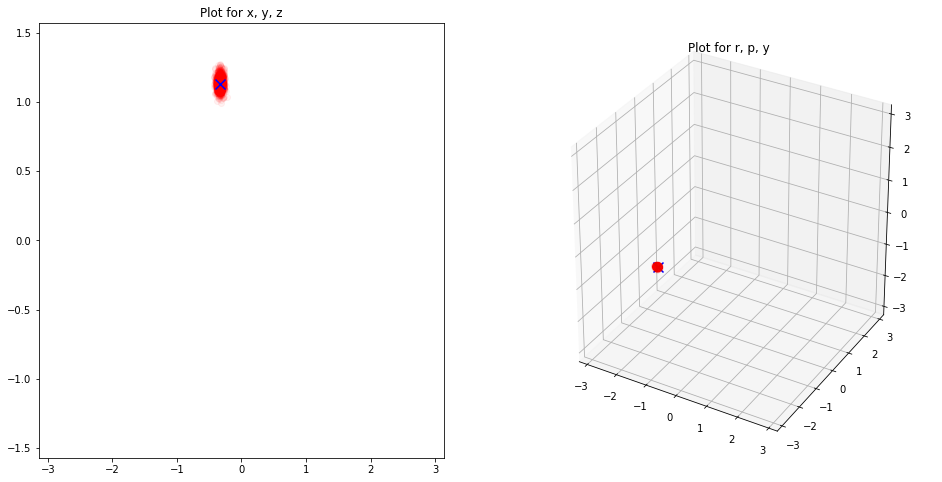

In [76]:
# Retrieve clusters
from sklearn.cluster import KMeans

num_clusters = 1

kmeans_model = KMeans(n_clusters = num_clusters).fit(S_new[:-1, :].T)
results = kmeans_model.cluster_centers_
print(results)

res = results.T

fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(121)
ax1.scatter(*S_new[:2,:m//4], c='red', alpha=0.05)
ax1.scatter(*res[:2,:], c='blue', marker='x', s=100)
ax1.set_xlim(*ranges[0])
ax1.set_ylim(*ranges[1])
ax1.set_title("Plot for x, y, z")

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(*S_new[2:,:m//4], c='red', alpha=0.05)
ax2.scatter(*res[2:,:], zdir='z', c='blue', marker='x', s=100)
ax2.set_xlim3d(*ranges[2])
ax2.set_ylim3d(*ranges[3])
ax2.set_zlim3d(*ranges[4])
ax2.set_title("Plot for r, p, y")
plt.show()

## 4. Check solution

In [77]:
# Compare rotation with ground truth by taking modulo wrt. 2pi
np.set_printoptions(suppress=True)

gt = np.array([*diff_sph]) % (2*pi)
for res_idx in range(results.shape[0]):
    r = results[res_idx, :] % (2*pi)
    print("Solution r:   " + str(r))
    print("Ground truth: " + str(gt))

    diff_r = np.minimum((r - gt) % (2*pi), (gt - r) % (2*pi))
    print("Difference:   " + str((np.around(diff_r,8))))
    print()
    
np.set_printoptions(suppress=None)

Solution r:   [5.94764624 1.13264824 5.51544873 3.37570681 0.25892946]
Ground truth: [5.94651049 1.12985649 0.5        5.88318531 5.28318531]
Difference:   [0.00113575 0.00279176 1.26773657 2.5074785  1.25892946]



In [78]:
# Construct E from solution t and r, check that (pts1)' E (pts2) = 0

from helpers import rpy2R, xyz2T, sphericalToCartesian

pts1_uvf = np.concatenate((pts1, np.ones((pts1.shape[0], 1))), axis = 1)
pts2_uvf = np.concatenate((pts2, np.ones((pts2.shape[0], 1))), axis = 1)

E_products = []
for res_idx in range(results.shape[0]):
    t  = sphericalToCartesian(1, *results[res_idx, :2])
    r  = results[res_idx, 2:]
    
    T = xyz2T(t[0], t[1], t[2])
    R = rpy2R(r[0], r[1], r[2])
    
#     E_product = []
#     for i in range(pts1_uvf.shape[0]):
#         E_product.append(pts1_uvf[i, :] @ T @ R @ pts2_uvf[i, :].T)
#     E_products.append(E_product)
    E_products.append(pts1_uvf @ T @ R @ pts2_uvf.T)

# for res in E_products:
#     print("Result number: " + str(res_idx))
#     for pt in res:
#         print(pt)
#     print()

Comparing only diagonal matches


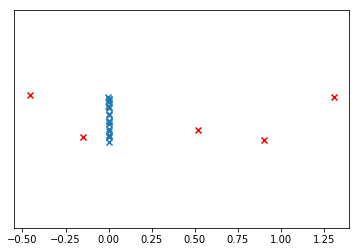

Comparing all n' x n matches


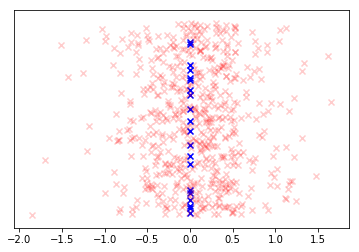

In [79]:
# Visualise (pts1)' E (pts2)

print("Comparing only diagonal matches")
for i in E_products:
    plt.scatter(np.diagonal(i)[:n_corr], np.random.rand(len(np.diagonal(i)[:n_corr]))*0.01, marker='x') # perturb vertically to see 
    plt.scatter(np.diagonal(i)[n_corr:], np.random.rand(len(np.diagonal(i)[n_corr:]))*0.01, marker='x', color='r') 
    plt.yticks([])
    plt.show()

print("Comparing all n' x n matches")
for sol in E_products:
    for i, row in enumerate(sol):
        for j, val in enumerate(row):
            
            if i == j and i < n_corr:
                plt.scatter(val, np.random.rand(), marker='x', color='b')
            else:
                plt.scatter(val, np.random.rand(), marker='x', color='r', alpha = 0.2)
    plt.yticks([])
    plt.show()

## 5. Check ground truth solution with (pts1)' E (pts2) = 0 for comparison

In [104]:
from helpers import rpy2R, xyz2T

t = np.array(diff)

T = xyz2T(t[0], t[1], t[2])
R = rpy2R(t[3], t[4], t[5])
E = np.dot(T, R)

for i in range(pts1_uvf.shape[0]):
    print(pts1_uvf[i, :] @ E @ pts2_uvf[i, :].T)

0.0003106021500309808
0.0004773595636866079
-0.00017362915397889367
0.00013278501946203947
0.0011474649252471991
0.001231552483543022
0.0002584667551119857
-0.0002852238917117056
0.001669861229592895
0.0006342972380445067
-0.0002692606155714483
0.0005203077812573897
0.0020286843713595015
-0.0002841698876872023
0.0005952680651337694
5.755934098239379e-05
-0.001393102651755962
0.00088644855485287
-0.0009351237932004874
0.0002680936139499712
-2.0949712049355074
-3.058733971600617
0.3450498254514176
-1.2239231299939552
1.0709736884487415
